In [2]:
%matplotlib inline
import sys


import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


import math,time
#import multiprocessing



import sys


import torch
#torch.multiprocessing.set_start_method("forkserver")

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import transforms, utils
from torchvision import models
from torch.utils.data import  Dataset, TensorDataset
import torchvision

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR







#sys.path.append('/mnt/home/e209440/')
#sys.path.append('/home/r120084/pytorch_lib/pytorch')
import lib.pytorch_trainer as ptt

from src.imgnet_utils import my_transforms,denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                           statistical_analysis_image, classDistribution)
                           
from src.features_extractor import MyResNet, MyInception, ExtractFeatures


In [3]:
use_gpu = torch.cuda.is_available()
#cpu_count = 24 #torch.multiprocessing.cpu_count()

print('GPU available:', use_gpu)
#print('cpu_count: ', cpu_count)

GPU available: True



# Choose dataset 

In [4]:
#if use_gpu:
path2train = "/mnt/home/e209440/data/train" # with gpu 
path2test = "/mnt/home/e209440/data/test" 
'''
else:
    path2train = "/home/r120084/project/data/train" #server without gpu
    path2test = "/home/r120084/project/data/test"
    
'''    

'\nelse:\n    path2train = "/home/r120084/project/data/train" #server without gpu\n    path2test = "/home/r120084/project/data/test"\n    \n'

# Images transformation

In [5]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])


# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(), First try withouth Data Augmentation 
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


# Creating  Dataset & Dataloader

In [6]:
batch_size = 320

use_only = 0.5 # Use only is the percentage of the full dataset

In [7]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [8]:
dset_loaders = _create_dataLoader(dsets, batch_size, 10, use_gpu)

In [9]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(8970, {'test': 39863, 'train': 8970, 'valid': 2242})

# Plotting some examples

torch.Size([3, 224, 224]) torch.Size([320])


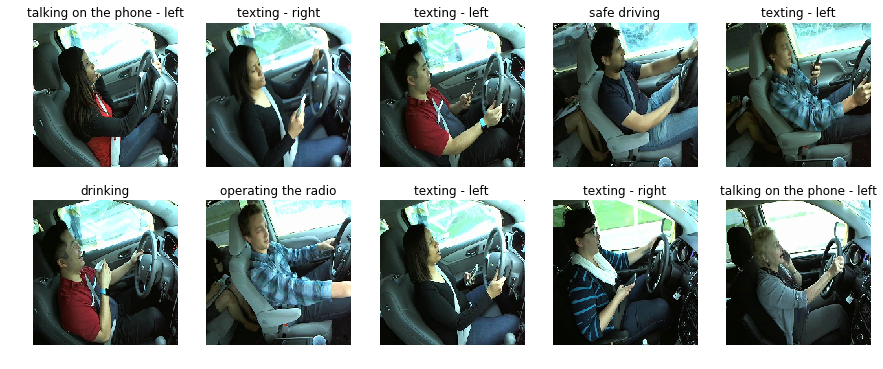

In [10]:
plot_classes(dset_loaders['train'])

# Data Analysis

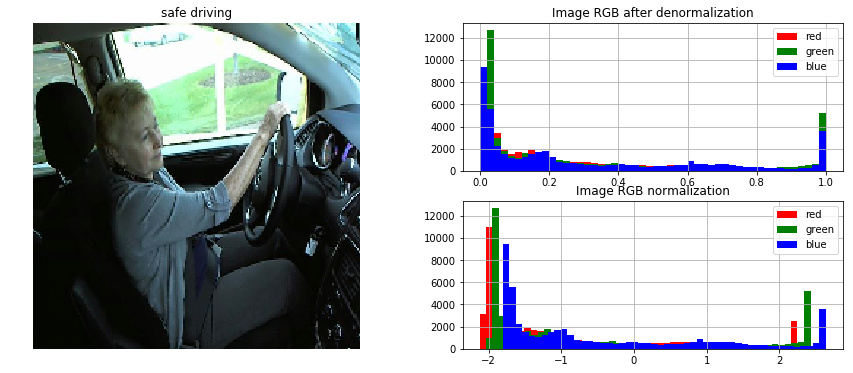

In [11]:
statistical_analysis_image(dset_loaders['train'])

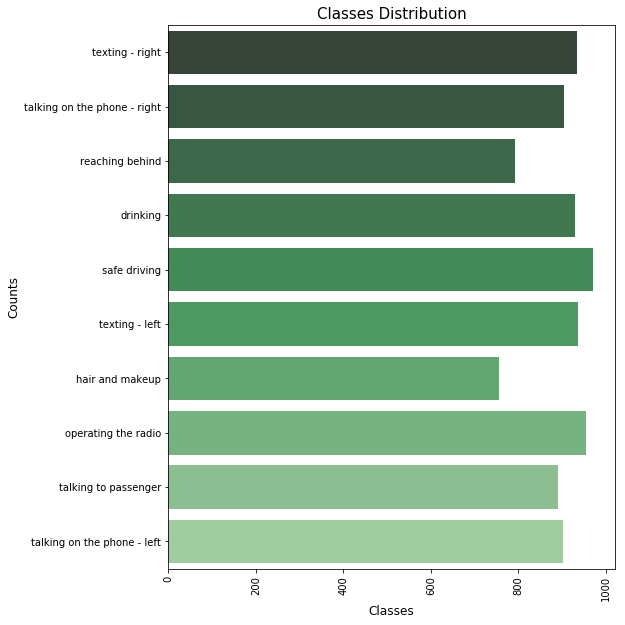

In [12]:
classDistribution(dsets['train'])

# Checking GPU usage

In [13]:
!free -h
!nvidia-smi
    

              total        used        free      shared  buff/cache   available
Mem:           220G         17G        149G        142M         53G        200G
Swap:            0B          0B          0B
Wed Nov 15 22:28:39 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   40C    P0    72W / 149W |   7777MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

# Choosing Model

In [14]:
use_resnet = True

if use_resnet:
    model = MyResNet()
else:
    model = myInception()

if use_gpu:
    model = torch.nn.DataParallel(model)
    model.cuda()

In [ ]:
#print(model)

In [ ]:
def predict(dset_loaders, model):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, (inputs, labels) in enumerate(dset_loaders):
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        labels_lst.append(labels)

        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'pred': torch.cat(predictions, 0), 'true':torch.cat(labels_lst, 0) }


In [15]:
if use_gpu:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.module.mrnc,use_gpu)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.module.mrnc,use_gpu)
else:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.mrnc)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.mrnc)



NameError: name 'Variable' is not defined

In [ ]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())

In [ ]:
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

In [ ]:
conv_dset ={
    'train': TensorDataset(convOutput_train['pred'], convOutput_train['true']),
    'valid': TensorDataset(convOutput_valid['pred'], convOutput_valid['true'])
} 

In [ ]:
dset_loaders_convnet = {
    'train': torch.utils.data.DataLoader(conv_dset['train'], 320,  shuffle=False),
    'valid': torch.utils.data.DataLoader(conv_dset['valid'], 320, shuffle=False)
}


In [ ]:
#dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, cpu_count, pin_memory=use_gpu, shuffle=False)


In [ ]:
len(dset_loaders_convnet['train'])

In [ ]:
#path2saveModel = '/home/r120084/project/models/distractdriver'
path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 

if use_gpu:    
 #   path2saveModel = '/mnt/home/r120084/project/models/distractdriver' 
    path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 
    
savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=1)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

if use_gpu:
    optimizer =  optim.Adam(model.module.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.module.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }

else:    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }
       
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)


In [ ]:
trainer = ptt.DeepNetTrainer(**params)

In [ ]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

In [ ]:
model.mrnd = trainer.model

In [ ]:
if use_gpu:
    !free -h
    !nvidia-smi

In [ ]:
path2save = './figures/results_metrics.png'

fig = plt.figure(figsize=(10,5))
metrics_map = {'losses': 'Loss', 'acc': 'Acuracy'}

metrics_eval_nb = len(trainer.metrics['train'].keys())
count = 1
for metric in trainer.metrics['train'].keys():
    plt.subplot(1,metrics_eval_nb, count)
    plt.plot(trainer.metrics['train'][metric], 'o-b', label = 'train')
    plt.plot(trainer.metrics['valid'][metric], 'o-r', label = 'valid')
    count += 1
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel(metrics_map[metric], fontsize = 12)
    plt.title(metrics_map[metric] + " during the model's training", fontsize = 16)
    plt.legend()
fig.savefig(path2save)

In [ ]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

In [ ]:
train_eval, valid_eval

In [ ]:
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size, cpu_count, pin_memory=use_gpu, shuffle=False)

In [ ]:
result_train = predict(dset_loaders_wshuffle['train'], model)
result_valid = predict(dset_loaders_wshuffle['valid'], model)

In [ ]:
def getPrediction(result_valid):
    _, predicted = torch.max(result_valid, 1)
    return predicted 

In [ ]:
def tensor2numpy(result):
    return result.numpy()

In [ ]:
result_train['pred'] = getPrediction(result_train['pred'])
result_valid['pred'] = getPrediction(result_valid['pred'])

In [ ]:
result_train['pred'] = tensor2numpy(result_train['pred'])
result_train['true'] = tensor2numpy(result_train['true'])

result_valid['pred'] = tensor2numpy(result_valid['pred'])
result_valid['true'] = tensor2numpy(result_valid['true'])

In [ ]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [ ]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

In [ ]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

In [ ]:
def visualize_predictions(dsets, lst, path2save = []):
    maxSubPlot = 4
    if len(lst)<4:
        maxSubPlot = len(lst)
    fig = plt.figure(figsize=(15,6))
    for i, j in enumerate(range(0,maxSubPlot)):
        fig.add_subplot(1, maxSubPlot, i+1)
        (inputs, output) = dsets[lst[j]]
        img = denormalize(inputs.numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        #plt.title('{0} / {1}'.format(labels['c'+str(output)],  labels[('c'+str(result_train['pred'][lst[j]]))]))    
        plt.title('{0} / {1}'.format(('c'+str(output)),  ('c'+str(result_train['pred'][lst[j]]))))    
        plt.axis('off')
    if len(path2save) !=0:
        fig.savefig(path2save)

In [ ]:
visualize_predictions(dsets['train'], lst_correct)

In [ ]:
visualize_predictions(dsets['train'], lst_incorrect)

In [ ]:
def plot_confusion(results):
    mc = np.array(pd.crosstab(results['pred'], results['true']))
    plt.imshow(mc/mc.sum(axis=1))
    plt.colorbar()
    plt.axis('off')

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot_confusion(result_train)
plt.title('Train dataset')
plt.subplot(1,2,2)
plot_confusion(result_valid)
plt.title('Valid dataset')

In [ ]:
def plot_layers_weight(img_width, img_height, conv_model = model.mrnc, ncols = 8, H = 14, W=30):


    rand_idx = random.randrange(0, len(dsets['train']))
    input, _ = dsets['train'][rand_idx]
    input = input.view(1, 3, img_width, img_height)

    if use_gpu:
        x = Variable(input.cuda())
    else:
        x = Variable(input)


    for name, layer in conv_model.named_children():
        x = layer(x)
        grid = torchvision.utils.make_grid(torch.transpose(x.data, 0, 1), normalize=True, 
                                           pad_value=1.0, padding=1).cpu().numpy()

        if name == 'max_pool':
            H /= 3/2
            W /= 3/2
        fig = plt.figure(figsize=(H,W))
        plt.imshow(grid.transpose((1,2,0)))
        plt.title(name)
        plt.axis('off')
        plt.show()

In [ ]:
plot_layers_weight(img_width=224, img_height=224)